In [2]:
import sys
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import math
sys.path.insert(1, '../')
np.random.seed(0)

# pio.templates.default = "simple_white"
# pio.templates.default = "plotly_white"
pio.renderers.default = "notebook"

In [277]:
exchange_rate = {'CNY': 6.9588, 'ZAR': 13.8691, 'KRW': 1120.456, 'SGD': 1.3718,
                 'THB': 32.9627, 'ARS': 37.7315, 'TWD': 30.8448, 'SAR': 3.752,
                 'USD': 1.0, 'MYR': 4.1797, 'SEK': 9.109, 'NZD': 1.4542,
                 'HKD': 7.8236, 'VND': 4.4e-05, 'IDR': 14330.4526,
                 'AUD': 1.3672, 'NOK': 8.5922, 'GBP': 0.7841, 'EUR': 0.8833,
                 'JPY': 113.4941, 'INR': 69.6475, 'PHP': 52.411, 'AED': 3.673,
                 'RUB': 67.0545, 'BHD': 0.377, 'CHF': 0.9984, 'OMR': 0.3851,
                 'UAH': 28.3135, 'CAD': 1.3296, 'TRY': 5.2118, 'PLN': 3.7887,
                 'ILS': 3.7211, 'PKR': 134.1847, 'DKK': 6.5934, 'RON': 4.1121,
                 'LKR': 179.3797, 'JOD': 0.7095, 'KWD': 0.3042, 'QAR': 3.6409,
                 'CZK': 22.9453, 'HUF': 285.9137, 'BRL': 3.8672,
                 'EGP': 17.9113, 'FJD': 2.1133, 'MXN': 20.3997, 'BDT': 84.1851,
                 'KZT': 375.1462, 'NGN': 365.7219, 'XPF': 105.4033,
                 'KHR': 0.00025, 'LAK': 8.6e-05}

def currency_convert_to_USD(value, currency):
    """
    Receives a money amount and a currency and converts it to USD
    :param value: The amount of money to convert
    :param currency: The original currency
    :return: The worth of this money in USD
    """
    if (currency not in exchange_rate):
        raise ValueError("The value of " + currency + " is not defined.")
    return value / exchange_rate[currency]


categorical_features = [
    'hotel_country_code',
    'accommadation_type_name',
    'charge_option',
    'customer_nationality',
    'guest_nationality_country_name',
    'origin_country_code',
    'language',
    'original_payment_method',
    'original_payment_type',
    'original_payment_currency',
    'cancellation_policy_code'
]

# column names in the data that has date type
date_type_cols = [
    "booking_datetime",
    "checkin_date",
    "checkout_date",
    "hotel_live_date",
    "cancellation_datetime"
]

# the features of the preprocessed data
selected_features = [
    "hotel_star_rating",
    "guest_is_not_the_customer",

    "no_of_adults",
    "no_of_children",
    "no_of_extra_bed",
    "no_of_room",

    "original_selling_amount",
    "original_payment_currency",
    
    "is_user_logged_in",
    "is_first_booking",
    
    "request_nonesmoke",
    "request_latecheckin",
    "request_highfloor",
    "request_largebed",
    "request_twinbeds",
    "request_airport",
    "request_earlycheckin",

    "booking_month",
    "booking_dayofweek",
    "no_of_nights",
    "checkin_since_booking",

    "noshow_penalty",
    "first_penalty",
    "first_ndays",
    "second_penalty",
    "second_ndays",
    
    "original_payment_type_Credit Card",
    "original_payment_type_Gift Card",
    "original_payment_type_Invoice",
    
    "charge_option_Pay Later",
    "charge_option_Pay Now",
    
    "accommadation_type_name_Apartment",
    "accommadation_type_name_Guest House / Bed & Breakfast",
    "accommadation_type_name_Hostel",
    "accommadation_type_name_Hotel",
    "accommadation_type_name_Resort",
    "accommadation_type_name_Serviced Apartment",
    "accommadation_type_name_other_accommadation",
]

# the target columns is cancelled_in_N where cancelled_in_N=1 iff the booking was
# cancelled within N days since the booking date. otherwise, cancelled_in_N=0
target_min_N = 7
target_max_N = 46
TARGETS = ["cancelled_in_"+str(n) for n in range(target_min_N, target_max_N+1,1)]


def load_data(filename):
    """
    Preprocess the data and return the dataFrame of it
    :param filename: the path of the data
    """

    X = pd.read_csv(filename)

    X["booking_month"] = pd.DatetimeIndex(X['booking_datetime']).month
    X["booking_dayofweek"] = pd.DatetimeIndex(X['booking_datetime']).dayofweek

    # convert "date" columns from strings to ints
    for col in date_type_cols:
        X[col] = pd.to_datetime(X[col])
        X[col] = X[col].map(dt.datetime.toordinal)

    X["no_of_nights"] = X["checkout_date"] - X["checkin_date"]

    X["checkin_since_booking"] = X["checkin_date"] - X["booking_datetime"]

    X["cancel_since_booking"] = X["cancellation_datetime"] - X["booking_datetime"]
    X.loc[X.cancel_since_booking < 0, "cancel_since_booking"] = -1

    # add target columns: cancelled_in_N is 1 iff booking was cancelled within N days from the booking date
    for n in range(target_min_N, target_max_N + 1, 1):
        X["cancelled_in_" + str(n)] = 0
        X.loc[(X.cancel_since_booking >= 0) & (X.cancel_since_booking <= n), "cancelled_in_" + str(n)] = 1

    # convert "is_user_logged_in" and "is_first_booking" from "True"\"False" to 1/0
    X["is_user_logged_in"] = X["is_user_logged_in"].map({True: 1, False: 0})
    X["is_first_booking"] = X["is_first_booking"].map({True: 1, False: 0})

    # ===== Parse cancellation_policy_code =====
    days_matches = X["cancellation_policy_code"].str.extractall("([\\d]+)(D)")[0].unstack()
    penalty_matches = X["cancellation_policy_code"].str.extractall("(D)([\\d]+[NP])")[1].unstack()
    noshow_matches = X["cancellation_policy_code"].str.extract("(_)([\\d]+[NP])")[1]

    X["noshow_penalty"] = noshow_matches
    X["first_penalty"]  = penalty_matches[0]
    X["first_ndays"]    = days_matches[0]
    X["second_penalty"] = penalty_matches[1]
    X["second_ndays"]   = days_matches[1]

    # if noshow_penalty is Nan assign "100P" to it
    X.loc[X.noshow_penalty.isnull(), "noshow_penalty"] = "100P"

    # if first_penalty is NaN assign noshow_penalty to it
    X.loc[X.first_penalty.isnull(), "first_penalty"] = X["noshow_penalty"]

    # if first_ndays is NaN assign 365 to it
    X.loc[X.first_ndays.isnull(), "first_ndays"] = 365

    # if second_penalty is NaN assign first_penalty to it
    X.loc[X.second_penalty.isnull(), "second_penalty"] = X["first_penalty"]

    # if second_ndays is NaN assign first_ndays to it
    X.loc[X.second_ndays.isnull(), "second_ndays"] = X["first_ndays"]
    
    X["first_ndays"]    = X["first_ndays"].astype(int)
    X["second_ndays"]   = X["second_ndays"].astype(int)
    # ===== End of parse cancellation_policy_code =====

    
    # ===== Proccess Categorical Features =======
    
    # == charge_option ==
    # value:  Pay Later  |  Pay Now  |  Pay at Check-in
    # count:     14454   |   44170   |       35
    X.loc[X.charge_option=="Pay at Check-in", "charge_option"] = "Pay Later"
    
    # == original_payment_type ==
    # value:  Credit Card  |  Gift Card  |  Gift Card
    # count:     57643     |     230     |    786

    most_common_accommadation_type = [
        'Hotel',
        'Resort',
        'Serviced Apartment',
        'Guest House / Bed & Breakfast',
        'Hostel',
        'Apartment',
    ]
    not_common_rows = ~X.accommadation_type_name.isin(most_common_accommadation_type)
    X.loc[not_common_rows , "accommadation_type_name"] = "other_accommadation"
    
    # convert to dummy
    X = pd.get_dummies(X, columns=["original_payment_type","charge_option","accommadation_type_name"])

    # clean
    X.loc[X.hotel_star_rating == -1, "hotel_star_rating"] = 0
    X.loc[X.first_ndays == '999', "first_ndays"] = 365
    X.loc[X.second_ndays == '999', "second_ndays"] = 365
    
    labels = X[TARGETS]
    return X, labels

X, labels = load_data("../datasets/agoda_cancellation_train.csv")

In [278]:

cols_to_print = [
    "cancellation_policy_code",
    "noshow_penalty",
    "first_penalty",
    "first_ndays",
    "second_penalty",
    "second_ndays",
    "no_of_nights",
    "original_selling_amount",
    "original_payment_currency",
    "USD"
    
]

X["USD"] = X.original_selling_amount
  
#selected_cols = ["cancelled_in_"+str(n) for n in range(min_N, max_N+1,1)]
X[cols_to_print]


#raw_X.iloc[X.loc[X.checkin_since_booking < 0,"h_booking_id"].index]


cancellation_policy_code noshow_penalty first_penalty  first_ndays  \
0                365D100P_100P           100P          100P          365   
1                      1D1N_1N             1N            1N            1   
2                      2D1N_1N             1N            1N            2   
3                    1D1N_100P           100P            1N            1   
4                 14D100P_100P           100P          100P           14   
...                        ...            ...           ...          ...   
58654                   1D100P           100P          100P            1   
58655              5D100P_100P           100P          100P            5   
58656            365D100P_100P           100P          100P          365   
58657            365D100P_100P           100P          100P          365   
58658            365D100P_100P           100P          100P          365   

      second_penalty  second_ndays  no_of_nights  original_selling_amount  \
0               100P           365             4                   267.55   
1                 1N             1             1                   114.15   
2                 1N             2             1                   115.79   
3                 1N             1             1                    68.74   
4               100P            14             1                   127.76   
...              ...           ...           ...                      ...   
58654           100P             1             1                    11.12   
58655           100P             5             2                    89.38   
58656           100P           365             2                   404.52   
58657           100P           365             2                    65.88   
58658           100P           365             2                   206.02   

      original_payment_currency  
0                           CNY  
1                           ZAR  
2                           KRW  
3                           SGD  
4                           THB  
...                         ...  
58654                       IDR  
58655                       PHP  
58656                       CNY  
58657                       MXN  
58658                       HKD  

[58659 rows x 9 columns]

In [271]:
# for col in X.columns:
#     print('"%s",'%col)
X[selected_features].dtypes

hotel_star_rating                                        float64
guest_is_not_the_customer                                  int64
no_of_adults                                               int64
no_of_children                                             int64
no_of_extra_bed                                            int64
no_of_room                                                 int64
original_selling_amount                                  float64
original_payment_currency                                 object
is_user_logged_in                                          int64
is_first_booking                                           int64
request_nonesmoke                                        float64
request_latecheckin                                      float64
request_highfloor                                        float64
request_largebed                                         float64
request_twinbeds                                         float64
request_airport          

In [259]:
selected_features = [
    "hotel_star_rating",
    "accommadation_type_name",
    "guest_is_not_the_customer",

    "no_of_adults",
    "no_of_children",
    "no_of_extra_bed",
    "no_of_room",


    "original_selling_amount",
    "original_payment_currency",
    
    "is_user_logged_in",
    "is_first_booking",
    
    "request_nonesmoke",
    "request_latecheckin",
    "request_highfloor",
    "request_largebed",
    "request_twinbeds",
    "request_airport",
    "request_earlycheckin",
    

    "booking_month",
    "booking_dayofweek",
    "no_of_nights",
    "checkin_since_booking",
    "cancel_since_booking",

    "noshow_penalty",
    "first_penalty",
    "first_ndays",
    "second_penalty",
    "second_ndays",
    
    "original_payment_type_Credit Card",
    "original_payment_type_Gift Card",
    "original_payment_type_Invoice",
    
    "charge_option_Pay Later",
    "charge_option_Pay Now",
]

for f in selected_features:
    print(" ==== "+f+" ====")
    print(X.groupby(f).count().h_booking_id)
    print()

 ==== hotel_star_rating ====
hotel_star_rating
0.0     2597
1.0     1686
1.5      692
2.0     6243
2.5     2231
3.0    17552
3.5     4215
4.0    15697
4.5     1448
5.0     6298
Name: h_booking_id, dtype: int64

 ==== accommadation_type_name ====
accommadation_type_name
Apartment                         1175
Guest House / Bed & Breakfast     2914
Hostel                            2633
Hotel                            42828
Resort                            5655
Serviced Apartment                1470
other_accommadation               1984
Name: h_booking_id, dtype: int64

 ==== guest_is_not_the_customer ====
guest_is_not_the_customer
0    46055
1    12604
Name: h_booking_id, dtype: int64

 ==== no_of_adults ====
no_of_adults
1      6886
2     40092
3      3618
4      5597
5       476
6      1162
7       101
8       370
9        58
10      125
11       14
12       79
13        4
14       19
15        5
16       22
17        2
18       23
20        2
27        2
30        1
38        1
Nam

In [196]:
X=X[:50]
X["noshow_panalty"] = ""
X["first_panalty"] = ""
X["first_ndays"] = 0
X["second_panalty"] = ""
X["second_ndays"] = 0

def set_first_panalty(row, days, panalty):
    if(days == -1):
        X.loc[row, "noshow_panalty"] = panalty
    else:
        X.loc[row, "first_ndays"] = days
        X.loc[row, "first_panalty"] = panalty


def set_second_panalty(row, days, panalty):
    if(days == -1):
        X.loc[row,"noshow_panalty"] = panalty
    else:
        X.loc[row,"second_ndays"] = days
        X.loc[row,"second_panalty"] = panalty

        
def parse_policy(policy):
    cases = policy.split("_")
    
    days = []
    panalties = []
    
    for case in cases:
        if 'D' in case:
            parts = case.split("D")
            days.append(int(parts[0]))
            panalties.append(parts[1])
        else:
            days.append(-1)
            panalties.append(case)
            
    return days, panalties



for i in range(len(X)):
    days, panalties = parse_policy(X.loc[i,"cancellation_policy_code"])
    set_first_panalty(i, days[0], panalties[0])
    if(len(days) > 1):
        set_second_panalty(i, days[1], panalties[1])
    if(len(days) > 2):
        X.loc[i,"noshow_panalty"] = panalties[2]
    

    
# all_policies = X["cancellation_policy_code"].unique()
# for p in all_policies:
#     parsed = parse_policy(p)
#     if len(parsed[0]) > 2 and parsed[0][2] == -1:
#         print("##### ",end='')
#         print(p + "--> " + str(parsed))

selected_cols = [
    "cancellation_policy_code",
    "noshow_panalty",
    "first_panalty",
    "first_ndays",
    "second_panalty",
    "second_ndays"
]
X[selected_cols]

cancellation_policy_code noshow_panalty first_panalty  first_ndays  \
0             365D100P_100P           100P          100P          365   
1                   1D1N_1N             1N            1N            1   
2                   2D1N_1N             1N            1N            2   
3                 1D1N_100P           100P            1N            1   
4              14D100P_100P           100P          100P           14   
5          7D1N_1D100P_100P           100P            1N            7   
6                   1D1N_1N             1N            1N            1   
7                   1D1N_1N             1N            1N            1   
8                    3D100P                         100P            3   
9             365D100P_100P           100P          100P          365   
10            365D100P_100P           100P          100P          365   
11            365D100P_100P           100P          100P          365   
12                   2D100P                         100P            2   
13          7D1N_3D50P_100P           100P            1N            7   
14              1D100P_100P           100P          100P            1   
15               3D50P_100P           100P           50P            3   
16               5D50P_100P           100P           50P            5   
17            365D100P_100P           100P          100P          365   
18            365D100P_100P           100P          100P          365   
19              2D100P_100P           100P          100P            2   
20               4D51P_100P           100P           51P            4   
21                   5D100P                         100P            5   
22                1D1N_100P           100P            1N            1   
23                   7D100P                         100P            7   
24            365D100P_100P           100P          100P          365   
25                  3D1N_1N             1N            1N            3   
26                   2D100P                         100P            2   
27            365D100P_100P           100P          100P          365   
28               1D20P_100P           100P           20P            1   
29                  1D1N_1N             1N            1N            1   
30        7D50P_3D100P_100P           100P           50P            7   
31                   5D100P                         100P            5   
32            365D100P_100P           100P          100P          365   
33            365D100P_100P           100P          100P          365   
34         3D1N_1D100P_100P           100P            1N            3   
35            365D100P_100P           100P          100P          365   
36                  23D100P                         100P           23   
37            365D100P_100P           100P          100P          365   
38            365D100P_100P           100P          100P          365   
39                   1D100P                         100P            1   
40            365D100P_100P           100P          100P          365   
41                7D1N_100P           100P            1N            7   
42                   1D100P                         100P            1   
43         3D1N_1D100P_100P           100P            1N            3   
44            365D100P_100P           100P          100P          365   
45               1D80P_100P           100P           80P            1   
46       4D100P_0D100P_100P           100P          100P            4   
47            365D100P_100P           100P          100P          365   
48         7D1N_3D100P_100P           100P            1N            7   
49            365D100P_100P           100P          100P          365   

   second_panalty  second_ndays  
0                             0  
1                             0  
2                             0  
3                             0  
4                             0  
5            100P             1  
6                             0  
7      

In [208]:
#X=X[:50]

# Parse cancellation_policy_code
days_matches = X["cancellation_policy_code"].str.extractall("([\\d]+)(D)")[0].unstack()
panalty_matches = X["cancellation_policy_code"].str.extractall("(D)([\\d]+[NP])")[1].unstack()
noshow_matches = X["cancellation_policy_code"].str.extract("(_)([\\d]+[NP])")[1]

X["noshow_panalty"] = noshow_matches
X["first_panalty"]  = panalty_matches[0]
X["first_ndays"]    = days_matches[0]
X["second_panalty"] = panalty_matches[1]
X["second_ndays"]   = days_matches[1]

# if noshow_panalty is Nan assign "100P" to it
X.loc[X.noshow_panalty.isnull(), "noshow_panalty"] = "100P"

# if first_panalty is NaN assign noshow_panalty to it
X.loc[X.first_panalty.isnull(), "first_panalty"] = X["noshow_panalty"]

# if first_ndays is NaN assign 365 to it
X.loc[X.first_ndays.isnull(), "first_ndays"] = 365

# if second_panalty is NaN assign first_panalty to it
X.loc[X.second_panalty.isnull(), "second_panalty"] = X["first_panalty"]

# if second_ndays is NaN assign first_ndays to it
X.loc[X.second_ndays.isnull(), "second_ndays"] = X["first_ndays"]



#X.loc[X.cancellation_policy_code=="100P","cancellation_policy_code"]

X[["cancellation_policy_code","noshow_panalty", "first_panalty", "first_ndays", "second_panalty", "second_ndays", ]]


cancellation_policy_code noshow_panalty first_panalty first_ndays  \
0             365D100P_100P           100P          100P         365   
1                   1D1N_1N             1N            1N           1   
2                   2D1N_1N             1N            1N           2   
3                 1D1N_100P           100P            1N           1   
4              14D100P_100P           100P          100P          14   
5          7D1N_1D100P_100P           100P            1N           7   
6                   1D1N_1N             1N            1N           1   
7                   1D1N_1N             1N            1N           1   
8                    3D100P           100P          100P           3   
9             365D100P_100P           100P          100P         365   
10            365D100P_100P           100P          100P         365   
11            365D100P_100P           100P          100P         365   
12                   2D100P           100P          100P           2   
13          7D1N_3D50P_100P           100P            1N           7   
14              1D100P_100P           100P          100P           1   
15               3D50P_100P           100P           50P           3   
16               5D50P_100P           100P           50P           5   
17            365D100P_100P           100P          100P         365   
18            365D100P_100P           100P          100P         365   
19              2D100P_100P           100P          100P           2   
20               4D51P_100P           100P           51P           4   
21                   5D100P           100P          100P           5   
22                1D1N_100P           100P            1N           1   
23                   7D100P           100P          100P           7   
24            365D100P_100P           100P          100P         365   
25                  3D1N_1N             1N            1N           3   
26                   2D100P           100P          100P           2   
27            365D100P_100P           100P          100P         365   
28               1D20P_100P           100P           20P           1   
29                  1D1N_1N             1N            1N           1   
30        7D50P_3D100P_100P           100P           50P           7   
31                   5D100P           100P          100P           5   
32            365D100P_100P           100P          100P         365   
33            365D100P_100P           100P          100P         365   
34         3D1N_1D100P_100P           100P            1N           3   
35            365D100P_100P           100P          100P         365   
36                  23D100P           100P          100P          23   
37            365D100P_100P           100P          100P         365   
38            365D100P_100P           100P          100P         365   
39                   1D100P           100P          100P           1   
40            365D100P_100P           100P          100P         365   
41                7D1N_100P           100P            1N           7   
42                   1D100P           100P          100P           1   
43         3D1N_1D100P_100P           100P            1N           3   
44            365D100P_100P           100P          100P         365   
45               1D80P_100P           100P           80P           1   
46       4D100P_0D100P_100P           100P          100P           4   
47            365D100P_100P           100P          100P         365   
48         7D1N_3D100P_100P           100P            1N           7   
49            365D100P_100P           100P          100P         365   

   second_panalty second_ndays  
0            100P          365  
1              1N            1  
2              1N            2  
3              1N            1  
4            100P           14  
5            100P            1  
6              1N            1  
7              1N            1  
8            100P            3  


In [219]:
col_to_show = categorical_features
nrows = int(len(col_to_show)/2)+1
fig = make_subplots(rows=nrows, cols=2, subplot_titles=col_to_show)

for i in range(len(col_to_show)):  
    fig.append_trace(go.Histogram(x=X[col_to_show[i]], nbinsx=20, name=col_to_show[i]),
                     row=math.floor(i/2)+1, col=i%2+1)
    fig.update_layout(bargap=0.2)
    #fig.update_layout(title=X.columns[i])

fig['layout'].update(height=120*len(col_to_show))
fig.show()

# for col in X.columns:
#     fig =go.Figure(go.Histogram(x=X[col], nbinsx=20, name=X.columns[i]))
#     fig.update_layout(bargap=0.2)
#     fig.update_layout(title=col)
#     fig.show()


In [40]:
df = X["original_selling_amount"]
fig =go.Figure(go.Histogram(x=df[df<2500], nbinsx=200, name=X.columns[i]))
fig.update_layout(bargap=0.2)
fig.update_layout(title="original_selling_amount")
fig.show()

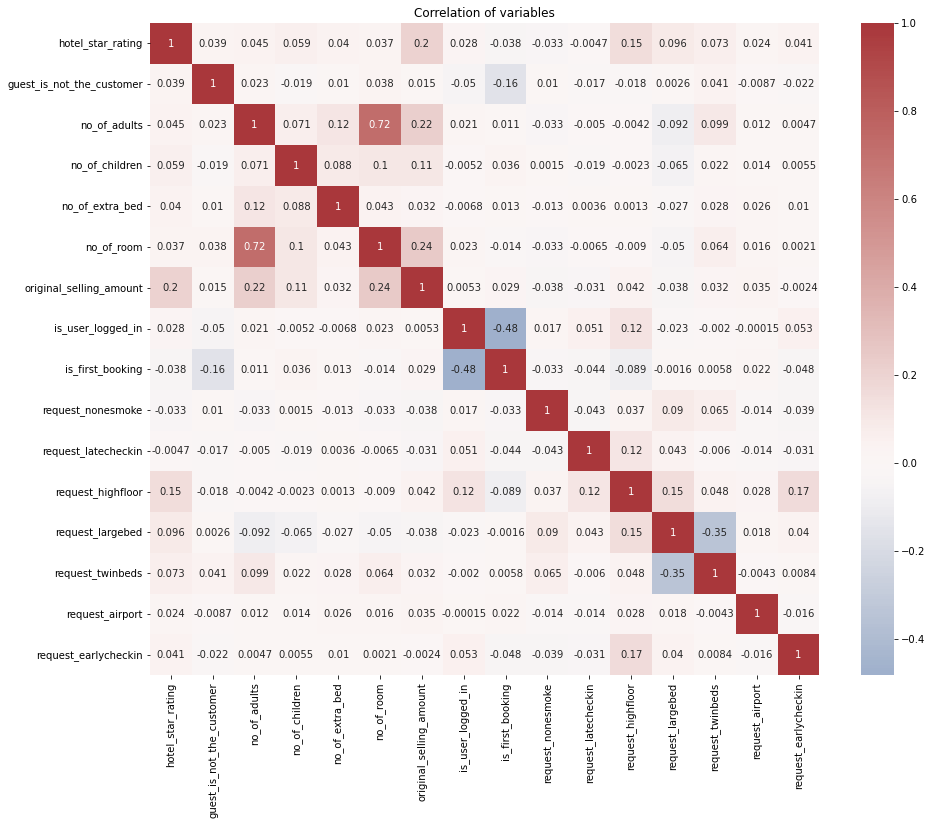

In [13]:

#corr = df_usa[['bathrooms', 'bedrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade', 'price']]

plt.figure(figsize=(15,12))
plt.title('Correlation of variables')
sns.heatmap(X[selected_cols].astype(float).corr(),vmax=1.0,  annot=True, cmap="vlag", center=0)
plt.show()

# Catagorial Columns

In [15]:
cat_features = [
    'hotel_country_code',
    'accommadation_type_name',
    'charge_option',
    'customer_nationality',
    'guest_nationality_country_name',
    'origin_country_code',
    'language',
    'original_payment_method',
    'original_payment_type',
    'original_payment_currency',
    'cancellation_policy_code'
]
X[cat_features]

hotel_country_code        accommadation_type_name charge_option  \
0                     HK                          Hotel       Pay Now   
1                     CN                          Hotel     Pay Later   
2                     KR                          Hotel       Pay Now   
3                     JP                          Hotel     Pay Later   
4                     TH                         Resort     Pay Later   
...                  ...                            ...           ...   
58654                 ID  Guest House / Bed & Breakfast       Pay Now   
58655                 PH                      Apartment       Pay Now   
58656                 TH                          Hotel       Pay Now   
58657                 DE                         Hostel       Pay Now   
58658                 HK                          Hotel       Pay Now   

      customer_nationality guest_nationality_country_name origin_country_code  \
0                    China                          China                  CN   
1             South Africa                   South Africa                  ZA   
2              South Korea                    South Korea                  KR   
3                Singapore                      Singapore                  SG   
4                 Thailand                       Thailand                  TH   
...                    ...                            ...                 ...   
58654            Indonesia                      Indonesia                  ID   
58655          Philippines                    Philippines                  PH   
58656                China                          China                  CN   
58657               Mexico                         Mexico                  MX   
58658                China                          China                  HK   

                       language original_payment_method original_payment_type  \
0          S.Chinese / Mainland                 UNKNOWN               Invoice   
1                       English                    Visa           Credit Card   
2                        Korean              MasterCard           Credit Card   
3      English / United Kingdom        American Express           Credit Card   
4                          Thai              MasterCard           Credit Card   
...                         ...                     ...                   ...   
58654                Indonesian              MasterCard           Credit Card   
58655                   English                  PayPal           Credit Card   
58656      S.Chinese / Mainland   UnionPay - Creditcard           Credit Card   
58657          Spanish / Mexico                    Visa           Credit Card   
58658      T.Chinese / Hongkong                    Visa           Credit Card   

      original_payment_currency cancellation_policy_code  
0                           CNY            365D100P_100P  
1                           ZAR                  1D1N_1N  
2                           KRW                  2D1N_1N  
3                           SGD                1D1N_100P  
4                           THB             14D100P_100P  
...                         ...                      ...  
58654                       IDR                   1D100P  
58655                       PHP              5D100P_100P  
58656                       CNY            365D100P_100P  
58657                       MXN            365D100P_100P  
58658                       HKD            365D100P_100P  

[58659 rows x 11 columns]

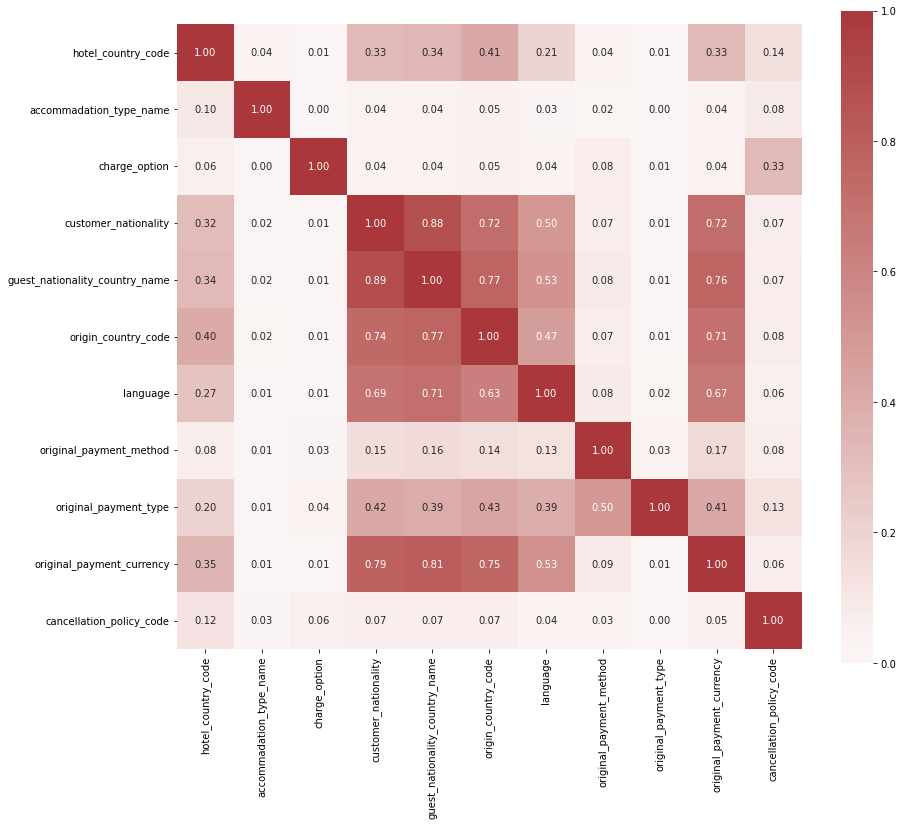

{'corr':                                 hotel_country_code  accommadation_type_name  \
 hotel_country_code                        1.000000                 0.038675   
 accommadation_type_name                   0.104828                 1.000000   
 charge_option                             0.060113                 0.003742   
 customer_nationality                      0.315646                 0.015094   
 guest_nationality_country_name            0.335892                 0.015595   
 origin_country_code                       0.400774                 0.017162   
 language                                  0.273441                 0.012960   
 original_payment_method                   0.077031                 0.011840   
 original_payment_type                     0.199779                 0.010048   
 original_payment_currency                 0.345716                 0.013798   
 cancellation_policy_code                  0.123044                 0.027437   
 
                              

In [34]:
from dython.nominal import associations
associations(X[cat_features],figsize=(14,12),nom_nom_assoc='theil', cmap="vlag")

In [ ]:
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [ ]:
A  a
A  b
B  f
B  d